In [14]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from keras import optimizers
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

<ipython-input-17-b9f0bb1fd076>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
df1 = pd.read_csv("C:\\Users\\nigel\\02_Brexit_Tweets_19_20\\files\\ALL_EVEN_SPLIT.csv")
df1['Created At'] = pd.to_datetime(df1['Created At']).dt.normalize()

In [3]:
df1.head()

,Content,Created At,Favorites,Location,Retweet-Count,TweetID,Username,Processed,Length,Words,Country,Polarity,Subjectivity,Label
0,There are 2099 hours until we leave the World'...,2019-01-01,0.0,UK & Germany,0.0,1.079890e+18,brexitbeater,"['hours', 'leave', 'world', 'large', 'trading'...",271,35,unknown,0.004762,0.576190,Positive
1,Welcome to the year of the #Brexit!,2019-01-01,0.0,unknown,0.0,1.079890e+18,ascherbaum,"['welcome', 'year', 'brexit']",35,7,unknown,0.800000,0.900000,Positive
2,Happy New Year to everyone! \n?????????? ?? ??...,2019-01-01,830.0,Yorkshire,194.0,1.079890e+18,RichardGCorbett,"['happy', 'new', 'year', 'everyone', 'rarely',...",182,32,unknown,0.318182,0.527273,Positive
3,Happy New Year people. \n\n#Brexit and #Climat...,2019-01-01,20.0,"Kildare, Ireland",0.0,1.079890e+18,ivancorless,"['happy', 'new', 'year', 'people', 'brexit', '...",231,38,unknown,0.345455,0.618182,Positive
4,"A very happy new year, dear brother @RaefMeeuw...",2019-01-01,4.0,unknown,0.0,1.079890e+18,mmeeuw,"['happy', 'new', 'year', 'dear', 'brother', 'm...",119,18,unknown,0.357576,0.651515,Positive


In [18]:
#import data
df = pd.read_csv('02_Brexit_Tweets_19_20/yahoo_GBPEUR.csv')
df.head()


,Date,High,Low,Open,Close,Volume,Adj Close
0,2019-01-01,1.11240,1.09740,1.11000,1.10790,0.0,1.10790
1,2019-01-02,1.11324,1.10710,1.11254,1.11264,0.0,1.11264
2,2019-01-03,1.10887,1.10300,1.10610,1.10570,0.0,1.10570
3,2019-01-04,1.11650,1.10740,1.10849,1.10851,0.0,1.10851
4,2019-01-07,1.11656,1.11215,1.11576,1.11593,0.0,1.11593


In [19]:
#filter column
dataset = df[['Open', 'High', 'Low', 'Close']]
dataset.head()

,Open,High,Low,Close
0,1.11000,1.11240,1.09740,1.10790
1,1.11254,1.11324,1.10710,1.11264
2,1.10610,1.10887,1.10300,1.10570
3,1.10849,1.11650,1.10740,1.10851
4,1.11576,1.11656,1.11215,1.11593


In [21]:
scaler = MinMaxScaler()
norm_data = scaler.fit_transform(dataset)
data = pd.DataFrame(data=norm_data, columns=['Open', 'High', 'Low', 'Close'])
data.head()

,Open,High,Low,Close
0,0.341705,0.248108,0.304827,0.329935
1,0.359328,0.254730,0.370873,0.362810
2,0.314646,0.220278,0.342957,0.314676
3,0.331229,0.280432,0.372915,0.334166
4,0.381669,0.280905,0.405256,0.385629


In [29]:
def load_data(data, seq_len):
    amount_of_features = len(data.columns)
    dataset = data.to_numpy() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(dataset) - sequence_length):
        result.append(dataset[index: index + sequence_length])

    result = np.array(result)
    days = round(0.9 * result.shape[0])     #split data training 
    train = result[:int(days), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(days):, :-1]
    y_test = result[int(days):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  
    
    return [x_train, y_train, x_test, y_test]

In [30]:
#lstm model
def build_model2(layers):
    
   
    d = 0.2
    model = Sequential()
    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
    model.add(Dense(16, activation='tanh'))     #tanh or relu   
    model.add(Dense(1,activation='tanh'))
        
    rmsprop = optimizers.RMSprop(lr=0.005)
    model.compile(loss='mse',optimizer='adam', metrics=[tf.keras.metrics.MeanSquaredError()])
    
    return model

In [31]:
#initialization
window = 2
test_split = 0.1
batch = 4

print('Loading data.....\n')

X_train, y_train, X_test, y_test = load_data(data, window)

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)


print('\nData loaded. \nTraining process...\n')

#choose model
model = build_model2([4,window,1])
model.summary()
#fit data into model
history = model.fit(
                    X_train,
                    y_train,
                    batch_size=batch,
                    epochs = 800,
                    validation_split=test_split,
                    verbose=1)


Loading data.....

X_train (451, 2, 4)
y_train (451,)
X_test (50, 2, 4)
y_test (50,)

Data loaded. 
Training process...

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 2, 128)            68096     
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 128)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        

102/102 [==============================] - 0s 3ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 8.1946e-04 - val_mean_squared_error: 8.1946e-04
Epoch 43/800
102/102 [==============================] - 0s 3ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 7.0064e-04 - val_mean_squared_error: 7.0064e-04
Epoch 44/800
102/102 [==============================] - 0s 3ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 7.8869e-04 - val_mean_squared_error: 7.8869e-04
Epoch 45/800
102/102 [==============================] - 0s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 6.0695e-04 - val_mean_squared_error: 6.0695e-04
Epoch 46/800
102/102 [==============================] - 0s 3ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 5.1322e-04 - val_mean_squared_error: 5.1322e-04
Epoch 47/800
102/102 [==============================] - 0s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0010 - val_mean_squared_err

102/102 [==============================] - 0s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 3.7487e-04 - val_mean_squared_error: 3.7487e-04
Epoch 90/800
102/102 [==============================] - 0s 3ms/step - loss: 8.9993e-04 - mean_squared_error: 8.9993e-04 - val_loss: 4.7153e-04 - val_mean_squared_error: 4.7153e-04
Epoch 91/800
102/102 [==============================] - 0s 3ms/step - loss: 9.9354e-04 - mean_squared_error: 9.9354e-04 - val_loss: 8.7195e-04 - val_mean_squared_error: 8.7195e-04
Epoch 92/800
102/102 [==============================] - 0s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 3.2716e-04 - val_mean_squared_error: 3.2716e-04
Epoch 93/800
102/102 [==============================] - 0s 3ms/step - loss: 9.3128e-04 - mean_squared_error: 9.3128e-04 - val_loss: 7.1982e-04 - val_mean_squared_error: 7.1982e-04
Epoch 94/800
102/102 [==============================] - 0s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.002

Epoch 136/800
102/102 [==============================] - 0s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 137/800
102/102 [==============================] - 0s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 4.5313e-04 - val_mean_squared_error: 4.5313e-04
Epoch 138/800
102/102 [==============================] - 0s 3ms/step - loss: 9.6703e-04 - mean_squared_error: 9.6703e-04 - val_loss: 7.1639e-04 - val_mean_squared_error: 7.1639e-04
Epoch 139/800
102/102 [==============================] - 0s 3ms/step - loss: 8.1893e-04 - mean_squared_error: 8.1893e-04 - val_loss: 3.3944e-04 - val_mean_squared_error: 3.3944e-04
Epoch 140/800
102/102 [==============================] - 0s 3ms/step - loss: 9.9662e-04 - mean_squared_error: 9.9662e-04 - val_loss: 3.3038e-04 - val_mean_squared_error: 3.3038e-04
Epoch 141/800
102/102 [==============================] - 0s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_

102/102 [==============================] - 0s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 3.9626e-04 - val_mean_squared_error: 3.9626e-04
Epoch 183/800
102/102 [==============================] - 0s 3ms/step - loss: 8.6895e-04 - mean_squared_error: 8.6895e-04 - val_loss: 3.2787e-04 - val_mean_squared_error: 3.2787e-04
Epoch 184/800
102/102 [==============================] - 0s 3ms/step - loss: 9.4069e-04 - mean_squared_error: 9.4069e-04 - val_loss: 3.7172e-04 - val_mean_squared_error: 3.7172e-04
Epoch 185/800
102/102 [==============================] - 0s 3ms/step - loss: 7.5741e-04 - mean_squared_error: 7.5741e-04 - val_loss: 6.5523e-04 - val_mean_squared_error: 6.5523e-04
Epoch 186/800
102/102 [==============================] - 0s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 3.0861e-04 - val_mean_squared_error: 3.0861e-04
Epoch 187/800
102/102 [==============================] - 0s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 

102/102 [==============================] - 0s 3ms/step - loss: 8.9037e-04 - mean_squared_error: 8.9037e-04 - val_loss: 5.0483e-04 - val_mean_squared_error: 5.0483e-04
Epoch 229/800
102/102 [==============================] - 0s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 6.7841e-04 - val_mean_squared_error: 6.7841e-04
Epoch 230/800
102/102 [==============================] - 0s 3ms/step - loss: 9.4956e-04 - mean_squared_error: 9.4956e-04 - val_loss: 4.4390e-04 - val_mean_squared_error: 4.4390e-04
Epoch 231/800
102/102 [==============================] - 0s 3ms/step - loss: 9.9091e-04 - mean_squared_error: 9.9091e-04 - val_loss: 3.0826e-04 - val_mean_squared_error: 3.0826e-04
Epoch 232/800
102/102 [==============================] - 0s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 3.0665e-04 - val_mean_squared_error: 3.0665e-04
Epoch 233/800
102/102 [==============================] - 0s 3ms/step - loss: 8.8215e-04 - mean_squared_error: 8.8215e-04 - va

102/102 [==============================] - 0s 3ms/step - loss: 8.2218e-04 - mean_squared_error: 8.2218e-04 - val_loss: 3.2700e-04 - val_mean_squared_error: 3.2700e-04
Epoch 275/800
102/102 [==============================] - 0s 3ms/step - loss: 7.1419e-04 - mean_squared_error: 7.1419e-04 - val_loss: 3.0418e-04 - val_mean_squared_error: 3.0418e-04
Epoch 276/800
102/102 [==============================] - 0s 3ms/step - loss: 7.2334e-04 - mean_squared_error: 7.2334e-04 - val_loss: 4.3120e-04 - val_mean_squared_error: 4.3120e-04
Epoch 277/800
102/102 [==============================] - 0s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 3.8066e-04 - val_mean_squared_error: 3.8066e-04
Epoch 278/800
102/102 [==============================] - 0s 3ms/step - loss: 8.5289e-04 - mean_squared_error: 8.5289e-04 - val_loss: 3.3247e-04 - val_mean_squared_error: 3.3247e-04
Epoch 279/800
102/102 [==============================] - 0s 3ms/step - loss: 8.9304e-04 - mean_squared_error: 8.9304e

Epoch 320/800
102/102 [==============================] - 0s 3ms/step - loss: 9.5139e-04 - mean_squared_error: 9.5139e-04 - val_loss: 4.6903e-04 - val_mean_squared_error: 4.6903e-04
Epoch 321/800
102/102 [==============================] - 0s 3ms/step - loss: 8.5330e-04 - mean_squared_error: 8.5330e-04 - val_loss: 4.5076e-04 - val_mean_squared_error: 4.5076e-04
Epoch 322/800
102/102 [==============================] - 0s 3ms/step - loss: 6.8278e-04 - mean_squared_error: 6.8278e-04 - val_loss: 3.2580e-04 - val_mean_squared_error: 3.2580e-04
Epoch 323/800
102/102 [==============================] - 0s 3ms/step - loss: 8.8437e-04 - mean_squared_error: 8.8437e-04 - val_loss: 4.5413e-04 - val_mean_squared_error: 4.5413e-04
Epoch 324/800
102/102 [==============================] - 0s 3ms/step - loss: 7.3480e-04 - mean_squared_error: 7.3480e-04 - val_loss: 3.8710e-04 - val_mean_squared_error: 3.8710e-04
Epoch 325/800
102/102 [==============================] - 0s 3ms/step - loss: 9.4589e-04 - mean_

102/102 [==============================] - 0s 3ms/step - loss: 8.2357e-04 - mean_squared_error: 8.2357e-04 - val_loss: 3.8439e-04 - val_mean_squared_error: 3.8439e-04
Epoch 366/800
102/102 [==============================] - 0s 3ms/step - loss: 7.7310e-04 - mean_squared_error: 7.7310e-04 - val_loss: 5.3067e-04 - val_mean_squared_error: 5.3067e-04
Epoch 367/800
102/102 [==============================] - 0s 3ms/step - loss: 6.5564e-04 - mean_squared_error: 6.5564e-04 - val_loss: 8.7108e-04 - val_mean_squared_error: 8.7108e-04
Epoch 368/800
102/102 [==============================] - 0s 3ms/step - loss: 8.7213e-04 - mean_squared_error: 8.7213e-04 - val_loss: 4.1832e-04 - val_mean_squared_error: 4.1832e-04
Epoch 369/800
102/102 [==============================] - 0s 3ms/step - loss: 9.6163e-04 - mean_squared_error: 9.6163e-04 - val_loss: 3.2470e-04 - val_mean_squared_error: 3.2470e-04
Epoch 370/800
102/102 [==============================] - 0s 3ms/step - loss: 8.5940e-04 - mean_squared_error:

102/102 [==============================] - 0s 3ms/step - loss: 7.7967e-04 - mean_squared_error: 7.7967e-04 - val_loss: 3.9708e-04 - val_mean_squared_error: 3.9708e-04
Epoch 411/800
102/102 [==============================] - 0s 3ms/step - loss: 7.4802e-04 - mean_squared_error: 7.4802e-04 - val_loss: 6.5406e-04 - val_mean_squared_error: 6.5406e-04
Epoch 412/800
102/102 [==============================] - 0s 3ms/step - loss: 8.5581e-04 - mean_squared_error: 8.5581e-04 - val_loss: 3.1140e-04 - val_mean_squared_error: 3.1140e-04
Epoch 413/800
102/102 [==============================] - 0s 3ms/step - loss: 7.1667e-04 - mean_squared_error: 7.1667e-04 - val_loss: 5.7624e-04 - val_mean_squared_error: 5.7624e-04
Epoch 414/800
102/102 [==============================] - 0s 3ms/step - loss: 9.6194e-04 - mean_squared_error: 9.6194e-04 - val_loss: 3.2371e-04 - val_mean_squared_error: 3.2371e-04
Epoch 415/800
102/102 [==============================] - 0s 3ms/step - loss: 7.7799e-04 - mean_squared_error:

102/102 [==============================] - 0s 3ms/step - loss: 8.3774e-04 - mean_squared_error: 8.3774e-04 - val_loss: 3.8600e-04 - val_mean_squared_error: 3.8600e-04
Epoch 456/800
102/102 [==============================] - 0s 3ms/step - loss: 8.7682e-04 - mean_squared_error: 8.7682e-04 - val_loss: 3.2312e-04 - val_mean_squared_error: 3.2312e-04
Epoch 457/800
102/102 [==============================] - 0s 3ms/step - loss: 8.7255e-04 - mean_squared_error: 8.7255e-04 - val_loss: 3.3856e-04 - val_mean_squared_error: 3.3856e-04
Epoch 458/800
102/102 [==============================] - 0s 3ms/step - loss: 6.9941e-04 - mean_squared_error: 6.9941e-04 - val_loss: 3.5477e-04 - val_mean_squared_error: 3.5477e-04
Epoch 459/800
102/102 [==============================] - 0s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 5.7414e-04 - val_mean_squared_error: 5.7414e-04
Epoch 460/800
102/102 [==============================] - 0s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - va

102/102 [==============================] - 0s 3ms/step - loss: 6.3471e-04 - mean_squared_error: 6.3471e-04 - val_loss: 7.8808e-04 - val_mean_squared_error: 7.8808e-04
Epoch 501/800
102/102 [==============================] - 0s 3ms/step - loss: 9.1491e-04 - mean_squared_error: 9.1491e-04 - val_loss: 4.5905e-04 - val_mean_squared_error: 4.5905e-04
Epoch 502/800
102/102 [==============================] - 0s 3ms/step - loss: 7.2129e-04 - mean_squared_error: 7.2129e-04 - val_loss: 3.5853e-04 - val_mean_squared_error: 3.5853e-04
Epoch 503/800
102/102 [==============================] - 0s 3ms/step - loss: 6.8505e-04 - mean_squared_error: 6.8505e-04 - val_loss: 5.0046e-04 - val_mean_squared_error: 5.0046e-04
Epoch 504/800
102/102 [==============================] - 0s 3ms/step - loss: 9.7751e-04 - mean_squared_error: 9.7751e-04 - val_loss: 3.1414e-04 - val_mean_squared_error: 3.1414e-04
Epoch 505/800
102/102 [==============================] - 0s 3ms/step - loss: 9.0856e-04 - mean_squared_error:

102/102 [==============================] - 0s 3ms/step - loss: 7.2529e-04 - mean_squared_error: 7.2529e-04 - val_loss: 7.4977e-04 - val_mean_squared_error: 7.4977e-04
Epoch 546/800
102/102 [==============================] - 0s 3ms/step - loss: 5.6765e-04 - mean_squared_error: 5.6765e-04 - val_loss: 4.3151e-04 - val_mean_squared_error: 4.3151e-04
Epoch 547/800
102/102 [==============================] - 0s 3ms/step - loss: 8.8811e-04 - mean_squared_error: 8.8811e-04 - val_loss: 3.8816e-04 - val_mean_squared_error: 3.8816e-04
Epoch 548/800
102/102 [==============================] - 0s 3ms/step - loss: 7.2720e-04 - mean_squared_error: 7.2720e-04 - val_loss: 5.7822e-04 - val_mean_squared_error: 5.7822e-04
Epoch 549/800
102/102 [==============================] - 0s 3ms/step - loss: 6.2232e-04 - mean_squared_error: 6.2232e-04 - val_loss: 5.0038e-04 - val_mean_squared_error: 5.0038e-04
Epoch 550/800
102/102 [==============================] - 0s 3ms/step - loss: 7.8831e-04 - mean_squared_error:

102/102 [==============================] - 0s 3ms/step - loss: 8.1491e-04 - mean_squared_error: 8.1491e-04 - val_loss: 3.4864e-04 - val_mean_squared_error: 3.4864e-04
Epoch 591/800
102/102 [==============================] - 0s 3ms/step - loss: 6.8824e-04 - mean_squared_error: 6.8824e-04 - val_loss: 3.3837e-04 - val_mean_squared_error: 3.3837e-04
Epoch 592/800
102/102 [==============================] - 0s 3ms/step - loss: 8.4785e-04 - mean_squared_error: 8.4785e-04 - val_loss: 4.0608e-04 - val_mean_squared_error: 4.0608e-04
Epoch 593/800
102/102 [==============================] - 0s 3ms/step - loss: 6.7762e-04 - mean_squared_error: 6.7762e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 594/800
102/102 [==============================] - 0s 3ms/step - loss: 7.6530e-04 - mean_squared_error: 7.6530e-04 - val_loss: 4.0306e-04 - val_mean_squared_error: 4.0306e-04
Epoch 595/800
102/102 [==============================] - 0s 3ms/step - loss: 6.5192e-04 - mean_squared_error: 6.5192e

102/102 [==============================] - 0s 3ms/step - loss: 5.5835e-04 - mean_squared_error: 5.5835e-04 - val_loss: 6.3212e-04 - val_mean_squared_error: 6.3212e-04
Epoch 636/800
102/102 [==============================] - 0s 3ms/step - loss: 8.1362e-04 - mean_squared_error: 8.1362e-04 - val_loss: 5.5677e-04 - val_mean_squared_error: 5.5677e-04
Epoch 637/800
102/102 [==============================] - 0s 3ms/step - loss: 8.1356e-04 - mean_squared_error: 8.1356e-04 - val_loss: 7.0476e-04 - val_mean_squared_error: 7.0476e-04
Epoch 638/800
102/102 [==============================] - 0s 3ms/step - loss: 8.9656e-04 - mean_squared_error: 8.9656e-04 - val_loss: 3.6439e-04 - val_mean_squared_error: 3.6439e-04
Epoch 639/800
102/102 [==============================] - 0s 3ms/step - loss: 8.4671e-04 - mean_squared_error: 8.4671e-04 - val_loss: 3.3419e-04 - val_mean_squared_error: 3.3419e-04
Epoch 640/800
102/102 [==============================] - 0s 3ms/step - loss: 7.1958e-04 - mean_squared_error:

102/102 [==============================] - 0s 3ms/step - loss: 6.2681e-04 - mean_squared_error: 6.2681e-04 - val_loss: 5.1836e-04 - val_mean_squared_error: 5.1836e-04
Epoch 681/800
102/102 [==============================] - 0s 3ms/step - loss: 7.5517e-04 - mean_squared_error: 7.5517e-04 - val_loss: 4.1534e-04 - val_mean_squared_error: 4.1534e-04
Epoch 682/800
102/102 [==============================] - 0s 3ms/step - loss: 6.3603e-04 - mean_squared_error: 6.3603e-04 - val_loss: 3.7440e-04 - val_mean_squared_error: 3.7440e-04
Epoch 683/800
102/102 [==============================] - 0s 3ms/step - loss: 5.4934e-04 - mean_squared_error: 5.4934e-04 - val_loss: 3.5662e-04 - val_mean_squared_error: 3.5662e-04
Epoch 684/800
102/102 [==============================] - 0s 3ms/step - loss: 8.7136e-04 - mean_squared_error: 8.7136e-04 - val_loss: 3.7590e-04 - val_mean_squared_error: 3.7590e-04
Epoch 685/800
102/102 [==============================] - 0s 3ms/step - loss: 7.7493e-04 - mean_squared_error:

102/102 [==============================] - 0s 3ms/step - loss: 6.5031e-04 - mean_squared_error: 6.5031e-04 - val_loss: 4.2689e-04 - val_mean_squared_error: 4.2689e-04
Epoch 726/800
102/102 [==============================] - 0s 3ms/step - loss: 8.4005e-04 - mean_squared_error: 8.4005e-04 - val_loss: 5.6878e-04 - val_mean_squared_error: 5.6878e-04
Epoch 727/800
102/102 [==============================] - 0s 3ms/step - loss: 7.2803e-04 - mean_squared_error: 7.2803e-04 - val_loss: 3.9312e-04 - val_mean_squared_error: 3.9312e-04
Epoch 728/800
102/102 [==============================] - 0s 3ms/step - loss: 6.5251e-04 - mean_squared_error: 6.5251e-04 - val_loss: 3.5940e-04 - val_mean_squared_error: 3.5940e-04
Epoch 729/800
102/102 [==============================] - 0s 3ms/step - loss: 7.2519e-04 - mean_squared_error: 7.2519e-04 - val_loss: 3.7523e-04 - val_mean_squared_error: 3.7523e-04
Epoch 730/800
102/102 [==============================] - 0s 3ms/step - loss: 7.0517e-04 - mean_squared_error:

102/102 [==============================] - 0s 3ms/step - loss: 7.1290e-04 - mean_squared_error: 7.1290e-04 - val_loss: 3.9532e-04 - val_mean_squared_error: 3.9532e-04
Epoch 771/800
102/102 [==============================] - 0s 3ms/step - loss: 7.6971e-04 - mean_squared_error: 7.6971e-04 - val_loss: 4.4411e-04 - val_mean_squared_error: 4.4411e-04
Epoch 772/800
102/102 [==============================] - 0s 3ms/step - loss: 6.7269e-04 - mean_squared_error: 6.7269e-04 - val_loss: 3.7831e-04 - val_mean_squared_error: 3.7831e-04
Epoch 773/800
102/102 [==============================] - 0s 3ms/step - loss: 7.5126e-04 - mean_squared_error: 7.5126e-04 - val_loss: 6.5235e-04 - val_mean_squared_error: 6.5235e-04
Epoch 774/800
102/102 [==============================] - 0s 3ms/step - loss: 8.2079e-04 - mean_squared_error: 8.2079e-04 - val_loss: 3.6023e-04 - val_mean_squared_error: 3.6023e-04
Epoch 775/800
102/102 [==============================] - 0s 3ms/step - loss: 7.3754e-04 - mean_squared_error:

In [32]:
#training error
print('Training error:- MSE: %.4f ' % history.history['loss'][-1])
print('\t\t RMSE: %.4f ' % math.sqrt(history.history['loss'][-1]))

#testing error
print('\nTesting error:- MSE: %.4f ' % history.history['val_loss'][-1])
print('\t\tRMSE: %.4f ' % math.sqrt(history.history['val_loss'][-1]))

Training error:- MSE: 0.0007 
		 RMSE: 0.0259 

Testing error:- MSE: 0.0005 
		RMSE: 0.0225 


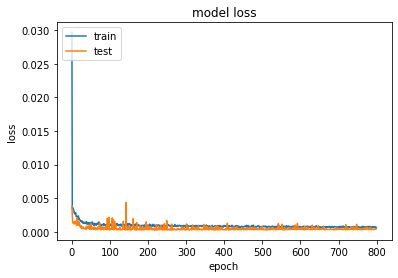

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
#print(X_test[-1])
diff=[]
ratio=[]
predict = model.predict(X_test)
test_dates = df1[['Created At']]
test_dates = test_dates.tail(30).values.tolist()
i=0
for stock_date in test_dates:
  polarity = df1['Polarity'].sum(axis = 0) 
  if polarity > 0:
    #positive sentiment
    predict[i]=predict[i]*1.001 # increase by 10%
  elif polarity < 0:
    #negative sentiment
    predict[i]=predict[i]*0.009 # decrease by 10%
  #for neutral sentiment - no change
  i+=1
print('data\t test\t\t\t prediction\t difference')
for u in range(len(y_test)):
    prediction = predict[u][0]
    ratio.append((y_test[u]/prediction)-1)
    diff.append(abs(y_test[u]- prediction))
    print(u, '\t' , y_test[u], '\t' , prediction, '\t' , '%.4f'% abs(y_test[u]- prediction))

data	 test			 prediction	 difference
0 	 0.321958644661418 	 0.34387997 	 0.0219
1 	 0.28637774097558655 	 0.3042383 	 0.0179
2 	 0.2893600414727455 	 0.30336002 	 0.0140
3 	 0.316063495633208 	 0.31744784 	 0.0014
4 	 0.31356653208970275 	 0.32383528 	 0.0103
5 	 0.3250798490908 	 0.34673747 	 0.0217
6 	 0.3459559525709217 	 0.3523821 	 0.0064
7 	 0.3438062488579705 	 0.33752283 	 0.0063
8 	 0.38132850035842214 	 0.37617442 	 0.0052
9 	 0.30954327891000144 	 0.34834266 	 0.0388
10 	 0.3563596917324876 	 0.3470381 	 0.0093
11 	 0.3316686909709965 	 0.32603765 	 0.0056
12 	 0.36974573139121425 	 0.35369718 	 0.0160
13 	 0.42724369123970973 	 0.44733006 	 0.0201
14 	 0.4305037996013148 	 0.47257176 	 0.0421
15 	 0.35504258480374506 	 0.37644908 	 0.0214
16 	 0.38611489835622237 	 0.3832734 	 0.0028
17 	 0.3773755259539522 	 0.37604657 	 0.0013
18 	 0.395269328936914 	 0.39550248 	 0.0002
19 	 0.4056730680984799 	 0.42264044 	 0.0170
20 	 0.3888193909889388 	 0.411047 	 0.0222
21 	 0.4214

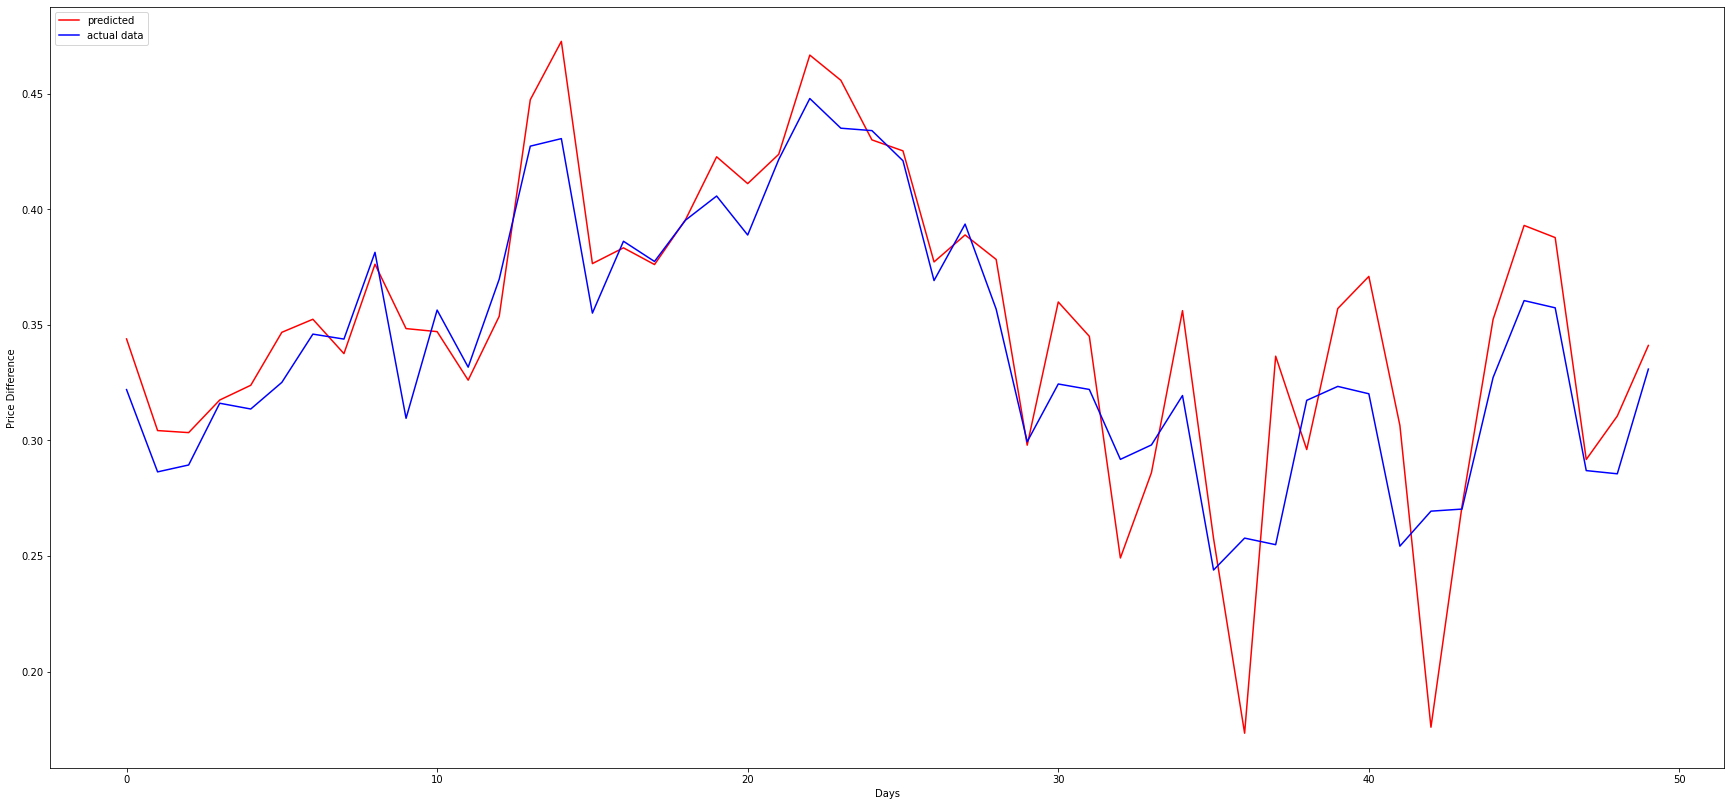

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 14))
plt.plot(predict,color='red', label='predicted')
plt.plot(y_test,color='blue', label='actual data')
plt.ylabel('Price Difference')
plt.xlabel('Days')
plt.legend(loc='upper left')
plt.show()